### Feature Selection

Feature Selection is one of the core concepts in machine learning which hugely impacts the performance of your model. The data features that you use to train your machine learning models have a huge influence on the performance you can achieve.

Irrelevant or partially relevant features can negatively impact model performance.

### Benefits of performing feature selection:

- Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise(irrelevant data).
- Improves Performance: Less misleading data means model's performance improves.
- Reduces Training Time: Less data means that algorithms train faster.

**Out of the numerous feature selection techniques, we'll be discussing 4 here.**

1. Recursive Feature Elimination (RFE)
1. Feature Importance using Random Forest
1. Boruta
1. XGBoost

### About Dataset

**Context**

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

**Content**

The datasets consists of several medical predictor variables and one target variable, class (whether patient have diabetes or not). Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

**Data Description**

- preg: Number of times the patient had been pregnant
- glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- bp: Diastolic blood pressure (mm Hg)
- skin: Triceps skin fold thickness (mm)
- insulin: 2-Hour serum insulin (mu U/ml)
- bmi: Body mass index (weight in kg/(height in m)^2)
- pedi: Diabetes pedigree function
- age: Age of the patient in years
- class: Have diabetes or not (0 means have no diabetes; 1 means have diabetes); 268 of 768 are 1, the others are 0

In [2]:
# Importing packages
import numpy as np # for array related operations
import pandas as pd # to read csv
import matplotlib.pyplot as plt # for visualisation
import seaborn as sns # for visualisation

# ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load data

col_names = ['preg', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedi', 'age', 'class']
data = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/pima-indians-diabetes.csv", names=col_names)
# names=col_names assigns the given names to the DataFrame columns (just to make the names shorter)

data.head()

,preg,glucose,bp,skin,insulin,bmi,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   preg     768 non-null    int64  
 1   glucose  768 non-null    int64  
 2   bp       768 non-null    int64  
 3   skin     768 non-null    int64  
 4   insulin  768 non-null    int64  
 5   bmi      768 non-null    float64
 6   pedi     768 non-null    float64
 7   age      768 non-null    int64  
 8   class    768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Correlation Matrix with Heatmap

Heatmap makes it easy to identify which features are most related to the target variable

<AxesSubplot: >

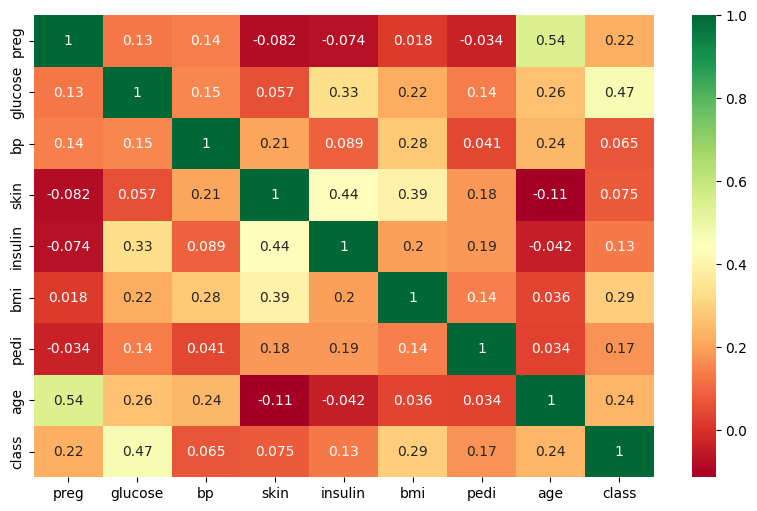

In [5]:
#get correlations of each features in dataset
corrmat = data.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corrmat, annot=True, cmap="RdYlGn")

We can see from an initial analysis of the heatmap that glucose, bmi, age, preg, pedi and insulin are the top 6 features that have relatively high correlation(positive) with class(our target variable). It means that as they increase, diabetes of the patient also increases.

Also, age and preg are highly correlated with each other.

Now, you might say why not remove irrelevant features by intuition or just looking at the heatmap?

In general it’s advisable not to be influenced by one’s bias or intuition.

In a real-life situation, we would have to deal with more than 3 features (from some hundreds to many thousands, typically). Thus, it would be unfeasible to go through each of them and decide whether to keep it or not. Moreover, there might be relationships among variables that are not easily spotted by a human eye, not even with accurate analysis.

Ideally, we would like to find an algorithm that is able to autonomously decide whether any given feature of X bears some predictive value about y.

In [6]:
# Splitting data into Input and Target Variable

y = data[['class']] # target variable i.e diabetic or not
X = data.drop(['class'], axis=1) # input variables

In [7]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.33,
random_state=1)

The **steps** that we'll follow will look like:

- Train a baseline classifier ( any classifier like logistic regression or random forest trained with all the features in dataset)
- Identify the most important features using a feature selection technique
- Create a new ‘limited features’ dataset containing only those features
- Train a second classifier on this new dataset
- Compare the accuracy of the ‘full featured’(baseline) classifier to the accuracy of the ‘limited featured’(new) classifier

### 1. Recursive Feature Elimination (RFE)

Recursive = Something that happens repeatedly

As the name suggests, Recursive Feature Elimination works by recursively(repeatedly) removing features and building a model on the features that remain.

The example below uses RFE with the logistic regression algorithm to select the top 3 features. The choice of algorithm does not matter, instead of logistic we can use any other algorithm that is skillful and consistent.

We use feature selection module from sklearn library to apply Recursive Feature Elimination (RFE)

**Train a Logistic Regression Model (Baseline Model)**

This is the basic Logistic Regression model we'll use to check if the first feature selection technique makes any improvements.

In [8]:
# Building the Logistic Regression model
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(random_state = 1)
lr_baseline_model = clf_lr.fit(X_train,y_train)

In [9]:
# Noting down accuracy of the baseline model
from sklearn.metrics import accuracy_score, f1_score

# finding our predicted values
y_pred = lr_baseline_model.predict(X_test)

# Calculating the accuracy and F1 Score by comparing the actual and predicted values
ac = accuracy_score(y_test, y_pred)
f_score = f1_score(y_test ,y_pred)

print("Baseline Model Accuracy:", ac)
print("Baseline Model F1 Score:", f_score)

Baseline Model Accuracy: 0.7795275590551181
Baseline Model F1 Score: 0.6455696202531646


**Applying RFE**

In [10]:
from sklearn.feature_selection import RFE #importing RFE class from sklearn library

rfe = RFE(estimator= clf_lr , step = 1)
# estimator clf_lr is the baseline model (basic model) that we have created under "Base line Model" selection
# step = 1: removes one feature at a time and then builds a model on the remaining features
# It uses the model accuracy to identify which features (and combination of features) contribute the most to predicting the target variable.
# we can even provide no. of features as an argument

# Fit the function for ranking the features
fit = rfe.fit(X_train, y_train)

print("Num Features: %d" % fit.n_features_) # no. of features
print("Selected Features: %s" % fit.support_) # selected features
print("Feature Ranking: %s" % fit.ranking_) # ranking of features

Num Features: 4
Selected Features: [ True  True False False False  True  True False]
Feature Ranking: [1 1 3 4 5 1 1 2]


**Representing feature ranks in the form of a table**

Through the output mentioned above we can't understand which feature has a better rank unless we see the index of each. In order to better visualise, we can put it in the form of a table with ranking as mentioned below.

In [11]:
selected_rfe_features = pd.DataFrame({'Feature':list(X_train.columns),
'Ranking':rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Feature,Ranking
0,preg,1
1,glucose,1
5,bmi,1
6,pedi,1
7,age,2
2,bp,3
3,skin,4
4,insulin,5


You can see that RFE gives preg, glucose, bmi and pedi the first rank.

**Create a new subset of the data with only the selected features**

To select important features you need to apply transformation on the dataset. We use .transform() to transform our dataset with important selected features. Always remember that train and test data must be transformed separately, else there might be data leak that hampers the model training.

In [12]:
# Transforming the data
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fitting our baseline model with the transformed data
lr_rfe_model = clf_lr.fit(X_train_rfe, y_train)

**Comparison of model performance with and without feature selection**

In [13]:
# making predictions and evaluating the model
y_pred_rfe = lr_rfe_model.predict(X_test_rfe)

rfe_ac = accuracy_score(y_test, y_pred_rfe)
rfe_fscore = f1_score(y_test ,y_pred_rfe)

print("RFE Model Accuracy:", rfe_ac)
print("RFE Model F1 Score:", rfe_fscore)

RFE Model Accuracy: 0.7795275590551181
RFE Model F1 Score: 0.641025641025641


We can see an improvement in both accuracy and F1 score as oppose to the baseline model (clf_lr) where we didn't apply feature selection

### 2. Feature Importance using Random Forest

Feature importance is another feature selection technique used to select features. It gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

Bagged decision trees models like Random Forest can be used to estimate the importance of features.

**Train a Random Forest Classifier (Baseline Model)**

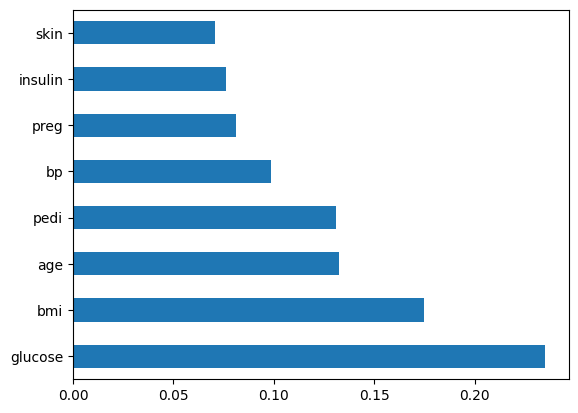

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
rf_clf = RandomForestClassifier(n_estimators=10000, random_state=1, n_jobs=-1)

# n_estimators = The number of trees in the forest.
# n_jobs = -1 : Use all processors for training

# Train the classifier
rf_clf.fit(X_train, y_train)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

The scores above are the importance scores for each variable. There are two things to note. First, all the importance scores add up to 100%.

Second, glucose, bmi, age, pedi are the top 4 features. The individual score of each is above 0.13. When combined, these 4 features have an importance of around 67.8%.

**Identify and Select Most Important Features**

In [15]:
from sklearn.feature_selection import SelectFromModel
# Create a selector object that will use the random forest classifier to identify
# It will select the features based on the importance score
rf_sfm = SelectFromModel(rf_clf)

#Alternatively if you want to set a specific threshold and select the features you may the following code that is commented
# features that have an importance of more than 0.13 ( all top 4 features lie above this)
# rf_sfm = SelectFromModel(rf_clf, threshold=0.13)

# Train the selector
rf_sfm = rf_sfm.fit(X_train, y_train)

**Create a new subset of the data with only the selected features**

To select important features you need to apply transformation on the dataset. We use .transform() to transform our dataset with important selected features. Always remember that train and test data must be transformed separately, else there might be data leak that hampers the model training.

In [16]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = rf_sfm.transform(X_train) # X_train is the input data
X_important_test = rf_sfm.transform(X_test) # X_test is the input data

**Train a new Random Forest Classifier using selected important features**

In [17]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=10000, random_state=1, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important = clf_important.fit(X_important_train, y_train)

**Comparison of model performance with and without feature selection**

In [18]:
y_pred = rf_clf.predict(X_test)
rf_ac = accuracy_score(y_test, y_pred)
rf_fscore = f1_score(y_test ,y_pred)

# View The Accuracy Of Our Full Feature (8 Features) Model
print("Baseline Model Accuracy:", rf_ac)
print("Baseline Model F1 Score:", rf_fscore)

Baseline Model Accuracy: 0.7913385826771654
Baseline Model F1 Score: 0.6666666666666666


In [19]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature (4 Features) Model
rf_imp_ac = accuracy_score(y_test, y_important_pred)
rf_imp_fscore = f1_score(y_test, y_important_pred)

print("Limited Features Model Accuracy:", rf_imp_ac)
print("Limited Features Model F1 Score:", rf_imp_fscore)

Limited Features Model Accuracy: 0.7716535433070866
Limited Features Model F1 Score: 0.6506024096385542


As can be seen by the above metrics, the accuracy and F1 Score of our original model which contained all eight features and ‘limited’ model which contained only two features is almost the same. We have halved the number of features in the model without changing the accuracy much, which is great!

### 3. Boruta

Boruta is an all-relevant feature selection method. Unlike other techniques that select small set of features to minimize the error, Boruta tries to capture all the important and interesting features you might have in your dataset with respect to the target variable.

Boruta by default uses random forest although it works with other algorithms like LightGBM, XGBoost etc.

NOTE: BorutaPy accepts numpy arrays only.

You can install Boruta with the command

pip install Boruta

In [20]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

**Train a Random Forest Classifier (Baseline Model)**

In [21]:
from boruta import BorutaPy

# define random forest classifier
forest = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=1)

forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=1)

In [22]:
# Apply The Full Featured Classifier To The Test Data
y_pred = forest.predict(X_test)
ac = accuracy_score(y_test, y_pred)
fscore = f1_score(y_test ,y_pred)

# View The Accuracy Of Our Full Feature (8 Features) Model
print("Baseline Model Accuracy:", ac)
print("Baseline Model F1 Score:", fscore)

Baseline Model Accuracy: 0.7834645669291339
Baseline Model F1 Score: 0.6451612903225805


**Applying Boruta use NumPy array for computational and other benefits**

In [23]:
# define Boruta feature selection method
# boruta_selector = BorutaPy(forest, n_estimators='auto', verbose=2)
boruta_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features
boruta_selector.fit(np.array(X_train), np.array(y_train))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	8
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	5
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	5
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	5
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	5
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	1
Iteration: 	13 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	1
Iteration: 	14 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	1
Iteration: 	15 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	1
Iteration: 	16 / 100
Confirmed: 	4
Tentative: 	3
Rejected: 	1
Iteration: 	17 / 

BorutaPy(estimator=RandomForestClassifier(max_depth=5, n_estimators=69,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x23D3E34D940),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x23D3E34D940, verbose=2)

In [24]:
# check selected features
print("Selected Features: ", boruta_selector.support_)

# check ranking of features
print("Ranking: ",boruta_selector.ranking_)

print("No. of significant features: ", boruta_selector.n_features_)

Selected Features:  [False  True False False  True  True  True  True]
Ranking:  [2 1 3 4 1 1 1 1]
No. of significant features:  5


In [25]:
# Let's visualise it better in the form of a table
selected_rfe_features = pd.DataFrame({'Feature':list(X_train.columns),
'Ranking':boruta_selector.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Feature,Ranking
1,glucose,1
4,insulin,1
5,bmi,1
6,pedi,1
7,age,1
0,preg,2
2,bp,3
3,skin,4


Our model gave glucose, insulin, bmi, pedi and age the first rank.

**Create a new subset of the data with only the selected features**

In [26]:
X_important_train = boruta_selector.transform(np.array(X_train))
X_important_test = boruta_selector.transform(np.array(X_test))

In [27]:
# Create a new random forest classifier for the most important features
rf_important = RandomForestClassifier(n_estimators=10000, random_state=1, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
rf_important.fit(X_important_train, y_train)

RandomForestClassifier(n_estimators=10000, n_jobs=-1, random_state=1)

**Comparison of model performance with and without feature selection**

In [28]:
# Apply The Limited Featured Classifier To The Test Data
y_important_pred = rf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature (4 Features) Model
rf_imp_ac = accuracy_score(y_test, y_important_pred)
rf_imp_fscore = f1_score(y_test, y_important_pred)

print("Limited Features Boruta Model Accuracy:", rf_imp_ac)
print("Limited Features Boruta Model F1 Score:", rf_imp_fscore)

Limited Features Boruta Model Accuracy: 0.7755905511811023
Limited Features Boruta Model F1 Score: 0.6586826347305389


The Accuracy has dropped and F1 Score has increased slightly on using Boruta. The no. of features have dropped from 8 to 5 however. This might be useful in cases where we want to reduce dimensionality even with some reduction in accuracy metrics.

### 4. XGBoost

Xgboost is short for eXtreme Gradient Boosting package.

XGBoost model has the best combination of prediction performance and processing time compared to other algorithms. No wonder it is widely used in recent Data Science competitions.

MUST READ: Learn about XGBoost here: https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d

!pip install xgboost

**Train a XGBoost Classifier (Baseline Model)**

Feature Importances :  [0.10440844 0.21552514 0.09496945 0.08279031 0.10608898 0.15713802
 0.0953111  0.1437686 ]


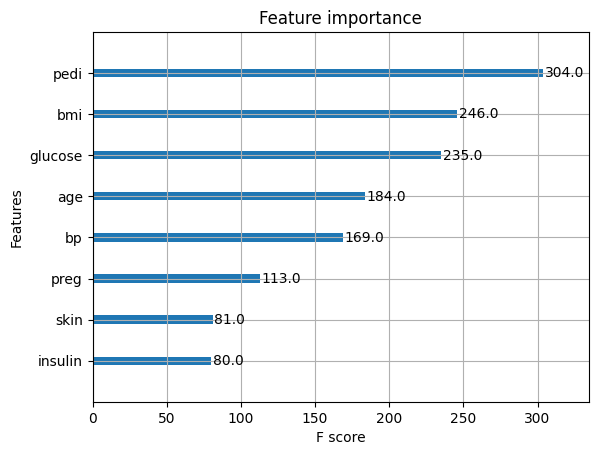

In [29]:
from xgboost import XGBClassifier
from xgboost import plot_importance

# fit model to training data
xgb_model = XGBClassifier(random_state = 0 )
xgb_model.fit(X_train, y_train)

print("Feature Importances : ", xgb_model.feature_importances_)

# plot feature importance
plot_importance(xgb_model)
plt.show()

XGBoost tells us that pedi, glucose, bmi and age are the top 4 features.

In [30]:
selection = SelectFromModel(xgb_model)
selection.fit(X_train, y_train)

# Transform the train and test features
select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)

# train model
selection_model = XGBClassifier()
selection_model.fit(select_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [31]:
y_pred = xgb_model.predict(X_test)

xgb_ac = accuracy_score(y_test, y_pred)
xgb_fscore = f1_score(y_test ,y_pred)

print("XGB Baseline Model Accuracy:", xgb_ac)
print("XGB Baseline Model F1 Score:", xgb_fscore)

XGB Baseline Model Accuracy: 0.7795275590551181
XGB Baseline Model F1 Score: 0.6744186046511628


In [32]:
# Evaluating the model
predictions = selection_model.predict(select_X_test) # predict for selected features of X_test
xgb_accuracy = accuracy_score(y_test, predictions) # Calculating accuracy score on test data
xgb_fscore = f1_score(y_test , predictions) # Calculating F1 score on test data


# View The Accuracy Of Our Limited Feature (4 Features) Model
print("Limited Features XGBoost Model Accuracy:", xgb_accuracy)
print("Limited Features XGBoost Model F1 Score:", xgb_fscore)

Limited Features XGBoost Model Accuracy: 0.7480314960629921
Limited Features XGBoost Model F1 Score: 0.6404494382022472


XGBoost was able to achieve a pretty good accuracy and F1 Score.

### Conclusion

- We started with observing the heatmap of our data and derived glucose, bmi, age, preg, pedi and insulin to be the top 6 positively correlated features.

- We first trained our baseline Logistic Regression model using all the features.

- On implementing the Recursive Feature Elimination technique(claimed preg, glucose, bmi, pedi as top 4 features) on Logistic Regression model, we observed significant change in both the metrics.

- Feature Importance technique using RandomForestClassifier stated that glucose, age, bmi, pedi and preg are the most important features of our dataset. Using this, we were able to half the number of features in the model without changing the accuracy.

- Boruta didn't improve the performance much but was able to reduce the number of features to 5.

- XGBoost gave us good results overall.

- After implementing the 4 techniques, we can see that all of them gave us similar set of important features.

### General Advice

- Start with simple techniques.
- Always check if what you're doing is helping(increasing your model's accuracy) or hurting.
- Don't assume that any given technique is useful.
- Not all the feature selection techniques are available in Sklearn. When you're coding a technique on your own, it's easier to make mistakes and that's a lot of work. Therefore, it's better to first focus on the techniques built in Sklearn itself.
- Feature selection is a decisive part of a machine learning pipeline: being too conservative means introducing unnecessary noise, while being too aggressive means throwing away useful information.

Watch this video you want to learn more about other feature selection techniques: https://www.youtube.com/watch?v=YaKMeAlHgqQ